<a href="https://colab.research.google.com/github/bboszori/ds_assesment/blob/main/05_classification_2_homework_bboszori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification homework

## Data
This is a dataset for binary sentiment classification. We provide a set of 50,000 highly polar movie reviews for training and testing.

## To do
Take the provided dataset and solve the binary classification task.

Target – sentiment pos/neg

## Evaluation
Metric AUC-ROC with visualisation

## Libraries
* scikit‑learn
* NLTK

##Criteria Scoring (100% in total)
* Text preprocessing with explanations of all steps (20% max):
  * Cleaning (5%)
  * Tokenization (5%)
  * Normalisation (comparison of stemming and lemmatization) (10%)
* Words importance (10%)
* Hyperparameters tuning (10%)
* Compare performance of models (20% max)
  * SGDClassifier
  * SVM
  * Naive Bayes
* Detailed conclusions (10%)
* Quality of delivered work (20% max):
  * Analytical comments provided (10%)
  * The experiment is structured: file is readable, pictures have titles, etc (5%)
  * Code is clear: reusable code in functions, comments,
code is easy readable, etc (5%)
* Extra points for improvements not considered in the criteria (10%)




In [ ]:
import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

import re
import string

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, roc_auc_score, confusion_matrix, roc_curve, classification_report, f1_score, RocCurveDisplay, make_scorer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD,SparsePCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.corpus import stopwords
stops = stopwords.words('english')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from collections import defaultdict
from collections import Counter

from wordcloud import WordCloud,STOPWORDS

from plotly import subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

plt.rcParams['figure.figsize'] = 10, 7
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
! ls '/content/gdrive/MyDrive/Data_Science_mentoring/06_classification_2'

classification_2_homework_bboszori.ipynb  LargeMovieReviewDataset.csv


In [ ]:
# Commonly used constants and paths
SEED = 42
DATA_PATH = '/content/gdrive/MyDrive/Data_Science_mentoring/06_classification_2'
DATA_FILE = f'{DATA_PATH}/LargeMovieReviewDataset.csv'
TARGET = 'sentiment'

In [ ]:
data = pd.read_csv(DATA_FILE)

## EDA: exploration of variables and properties of data with conclusions (10%)


In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
data.duplicated().sum()

418

In [ ]:
review = data['review']
data[review.isin(review[review.duplicated()])].sort_values("review").head(10)

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative
2976,"""Witchery"" might just be the most incoherent a...",negative
7949,'Dead Letter Office' is a low-budget film abou...,negative
32260,'Dead Letter Office' is a low-budget film abou...,negative
18022,(Spoilers)<br /><br />Oh sure it's based on Mo...,negative
22449,(Spoilers)<br /><br />Oh sure it's based on Mo...,negative


In [ ]:
data.drop_duplicates(inplace = True)

**I've found 418 duplicated lines, so I removed them**

<Figure size 1000x400 with 0 Axes>

[Text(0.5, 1.0, 'Target distribution')]

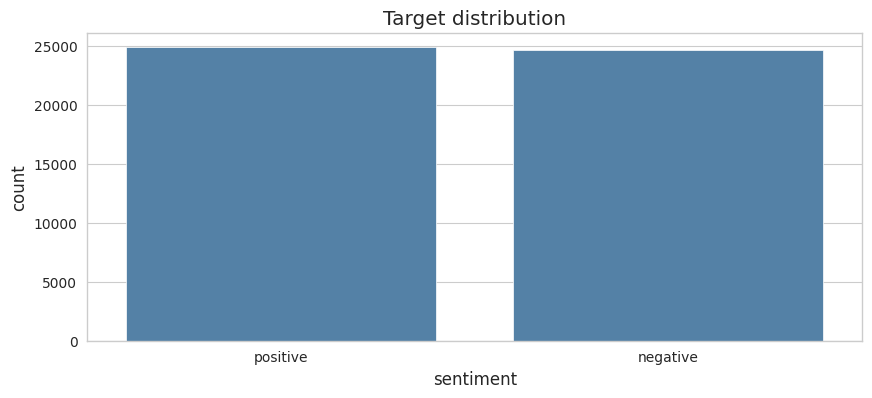

In [ ]:
plt.figure(figsize=(10,4))
sns.set_style("whitegrid")
sns.countplot(x=TARGET,data=data, color='steelblue').set(title='Target distribution')

In [ ]:
def plot_count(count_ones,count_zeros,title_1,title_2,subtitle):
  fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
  sns.set_style("whitegrid")
  sns.distplot(count_zeros,ax=ax1,color='steelblue')
  ax1.set_title(title_1)
  sns.distplot(count_ones,ax=ax2,color='navajowhite')
  ax2.set_title(title_2)
  fig.suptitle(subtitle)
  plt.show()

In [ ]:
def plot_count(data,subtitle):
  fig=plt.subplots(figsize=(10,4))
  sns.set_style("whitegrid")
  sns.histplot(x='count', hue='sentiment', data=data).set(title=subtitle)
  plt.show()

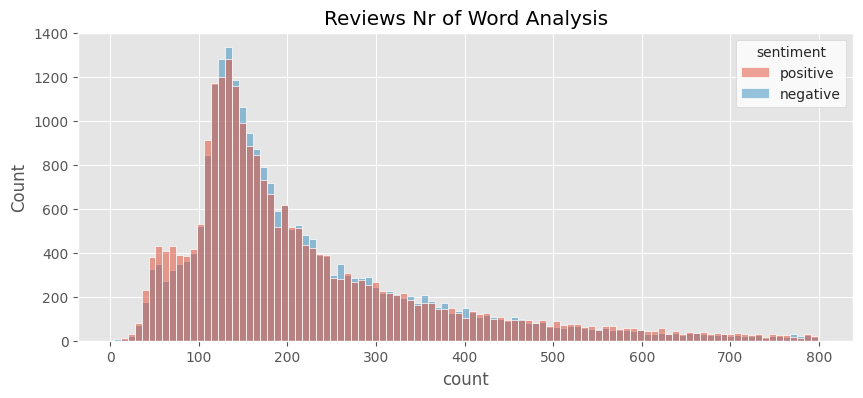

In [ ]:
nr_words = pd.DataFrame()
nr_words['sentiment'] = data['sentiment']
nr_words['count'] = data['review'].str.split().apply(lambda x:len(x))

plot_count(nr_words[nr_words['count']<800],"Reviews Nr of Word Analysis")

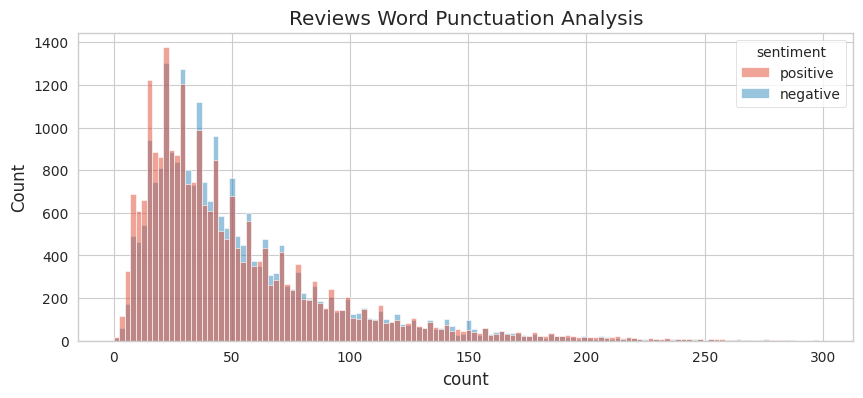

In [ ]:
nr_punct = pd.DataFrame()
nr_punct['sentiment'] = data['sentiment']
nr_punct['count'] = data['review'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
plot_count(nr_punct[nr_punct['count']<300],"Reviews Word Punctuation Analysis")

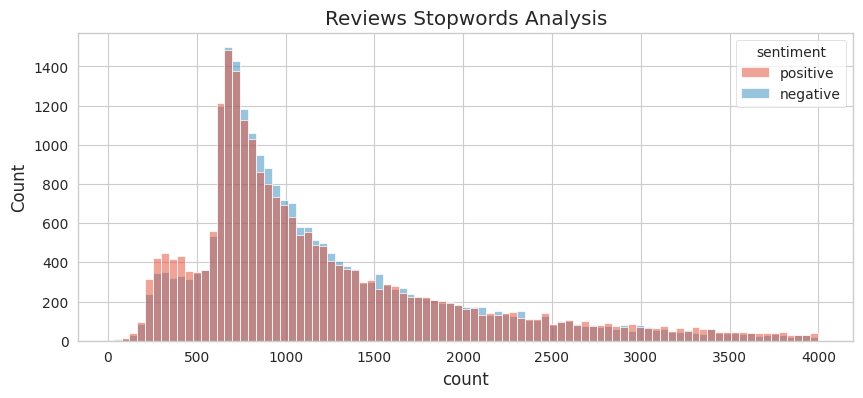

In [ ]:
nr_punct = pd.DataFrame()
nr_punct['sentiment'] = data['sentiment']
nr_punct['count'] = data['review'].apply(lambda x : np.mean([len(x) for w in str(x).split()]))
plot_count(nr_punct[nr_punct['count']<4000],"Reviews Stopwords Analysis")

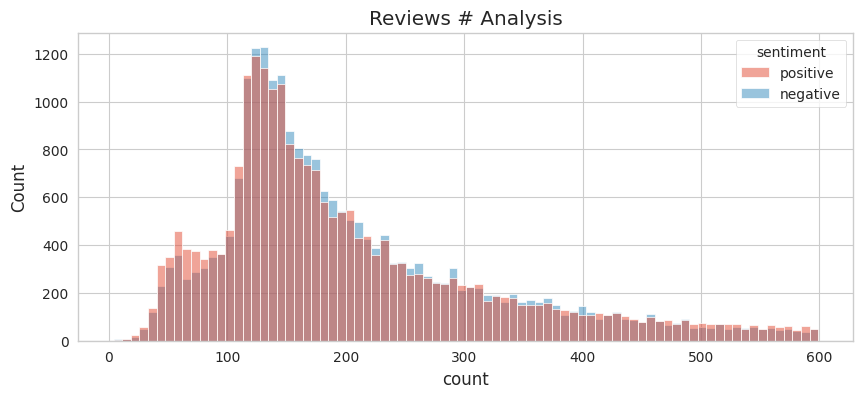

In [ ]:
nr_punct = pd.DataFrame()
nr_punct['sentiment'] = data['sentiment']
nr_punct['count'] = data['review'].apply(lambda x: len([w for w in str(x).lower().split() if '#']))
plot_count(nr_punct[nr_punct['count']<600],"Reviews # Analysis")

The data is balanced, we have the same number of positive and negative reviews.

And the analysis of the reviews shows similar distribution both for positive and negative reviews.

In [ ]:
def displayWordCloud(data, stopwords, title):
  wordcloud = WordCloud(width = 1000, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(data)


  plt.figure(figsize=(8,8))
  plt.imshow(wordcloud)
  plt.title(title)
  plt.axis('off')

In [ ]:
review = data['review']

pos_words =' '.join(map(str, review[data['sentiment']=='positive']))
neg_words =' '.join(map(str,review[data['sentiment']=='negative']))

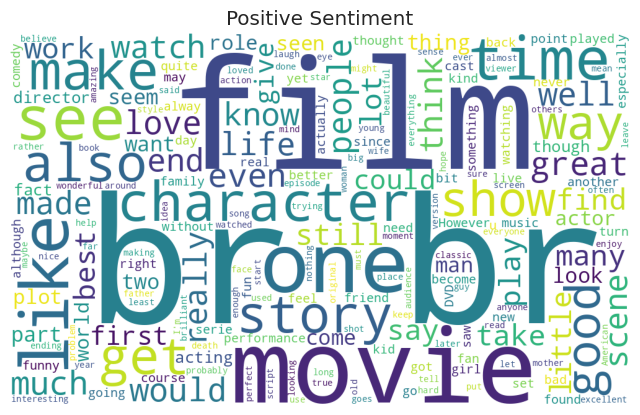

In [ ]:
displayWordCloud(pos_words, stops, 'Positive Sentiment')

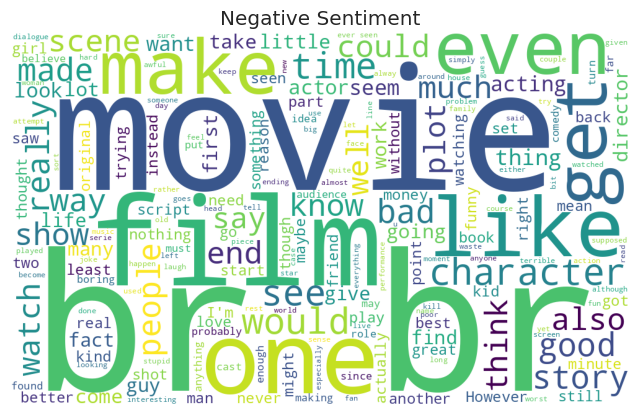

In [ ]:
displayWordCloud(neg_words, stops, 'Negative Sentiment')

In [ ]:
def get_ngrams(review, n, g):
  vec = CountVectorizer(ngram_range=(g, g)).fit(review)
  bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
  sum_words = bag_of_words.sum(axis=0) #total number of words
  sum_words = np.array(sum_words)[0].tolist() #convert to list
  words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency

  return words_freq[:n]

<Axes: xlabel='Count', ylabel='Common_words'>

Text(0.5, 1.0, 'Positive reviews')

<Axes: xlabel='Count', ylabel='Common_words'>

Text(0.5, 1.0, 'Negative reviews')

Text(0.5, 0.98, 'Bigram analysis for positive and negative reviews')

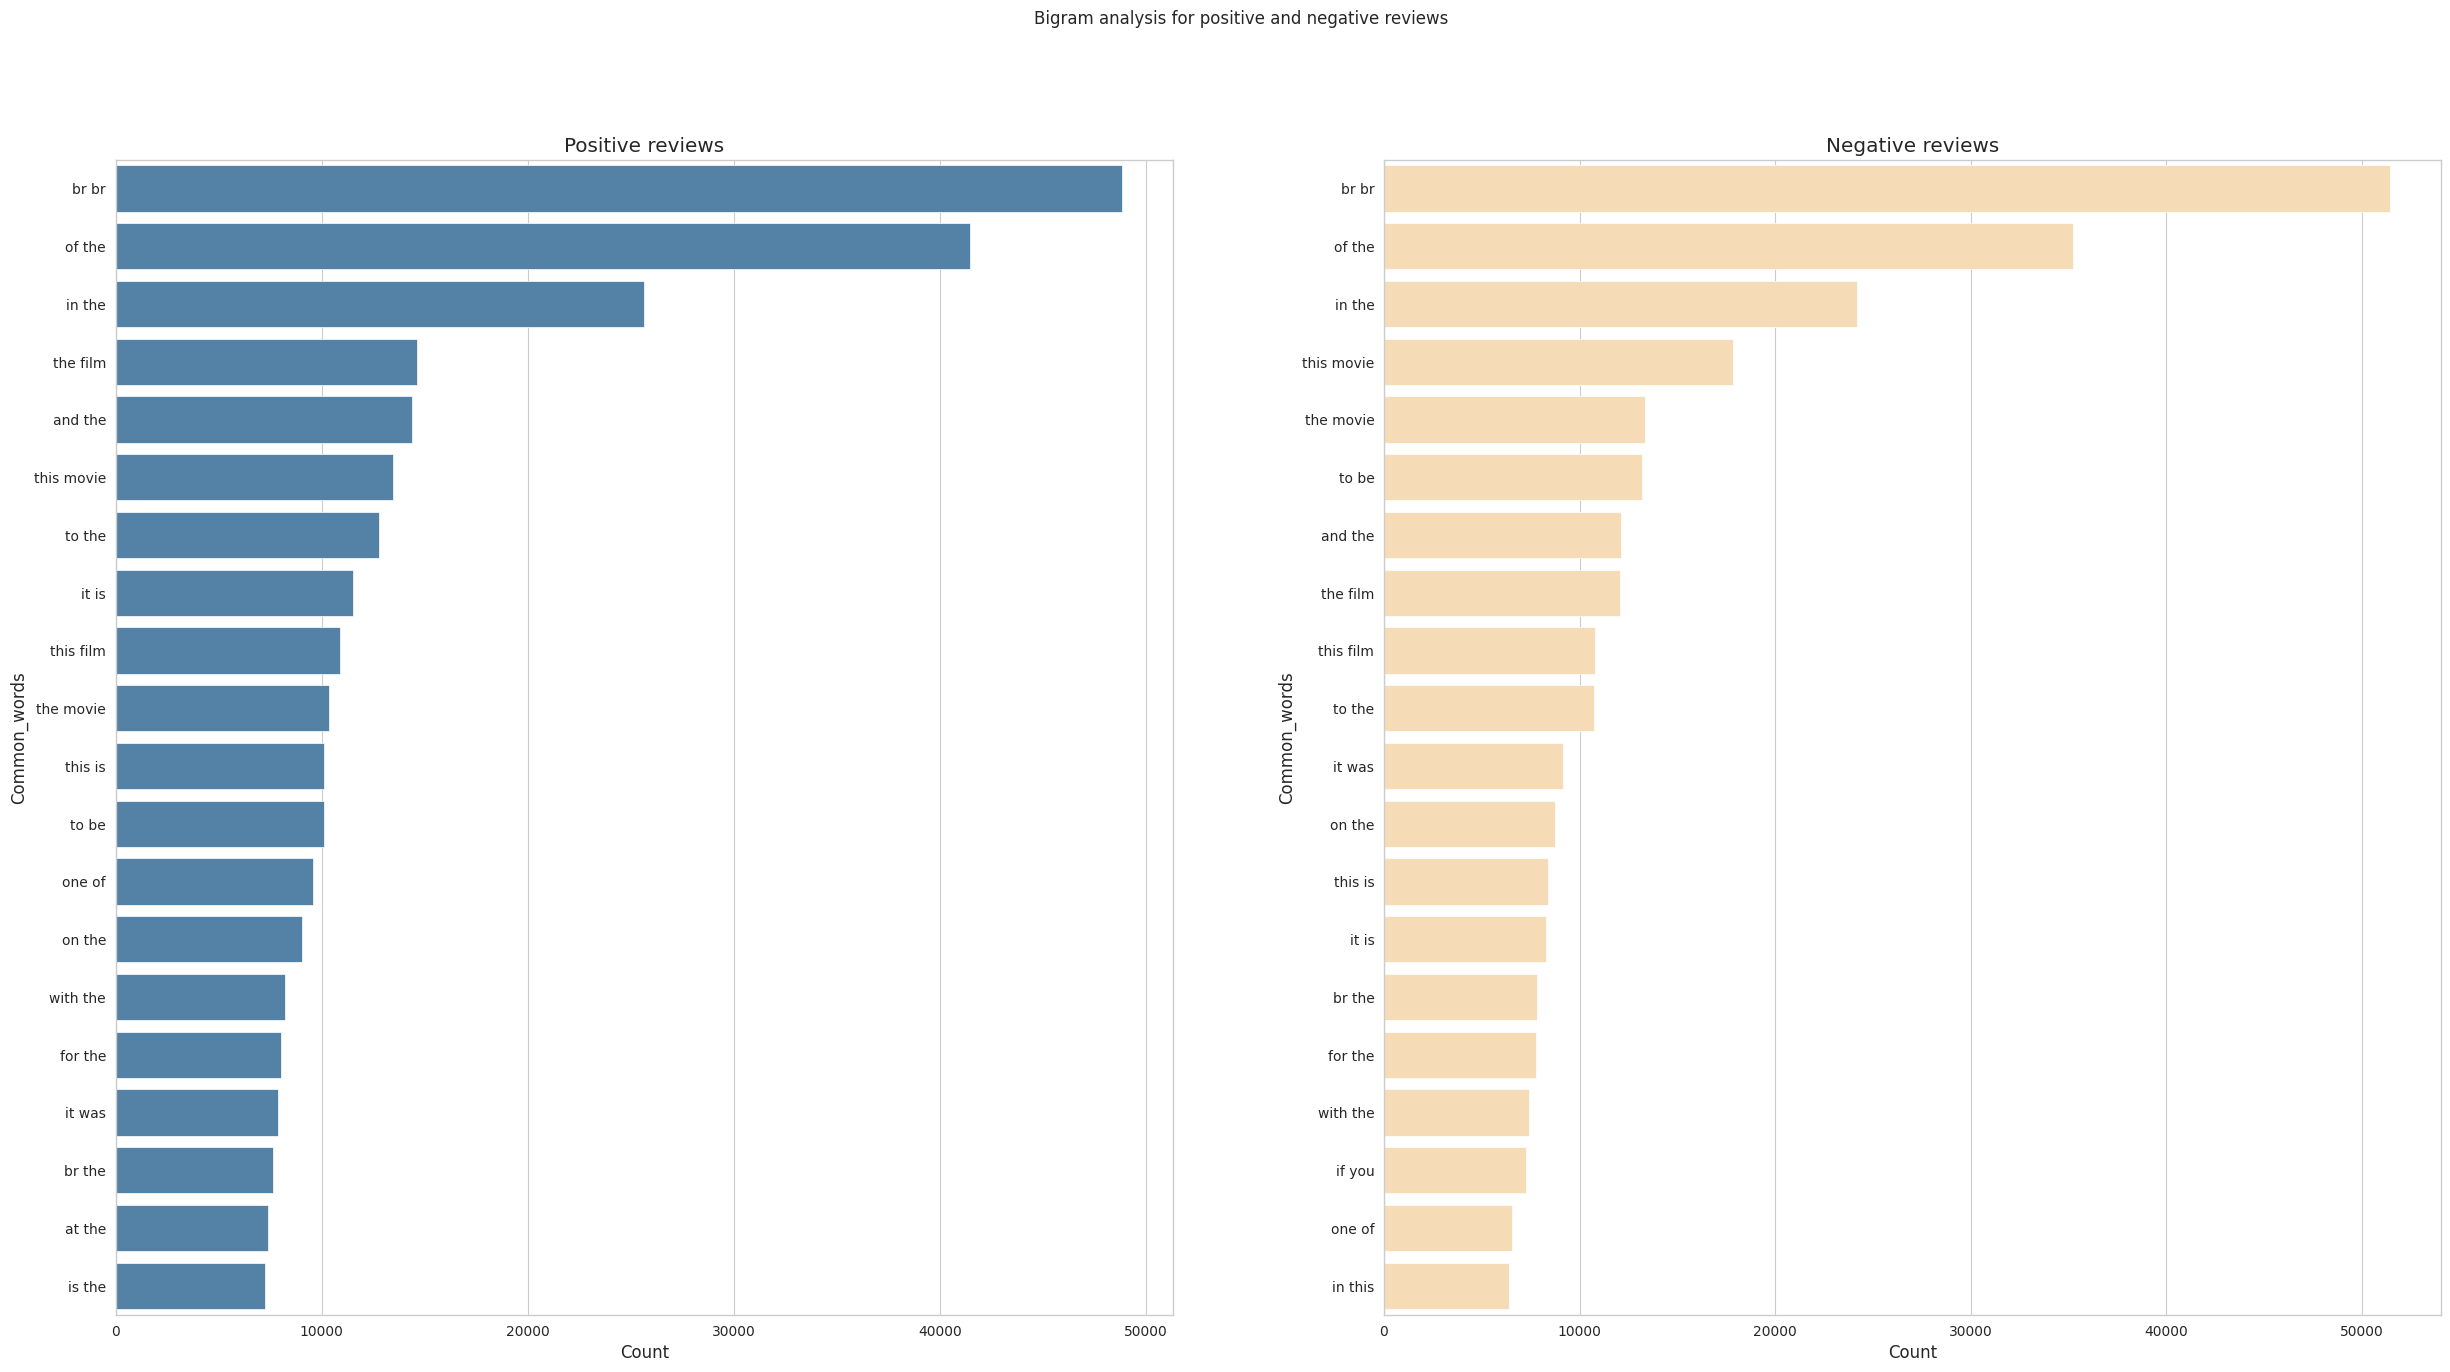

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
bi_positive = get_ngrams(data[data['sentiment']=='positive']['review'],20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1, color='steelblue')
ax1.set_title('Positive reviews')
bi_negative = get_ngrams(data[data['sentiment']=='negative']['review'],20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2, color='navajowhite')
ax2.set_title('Negative reviews')
fig.suptitle('Bigram analysis for positive and negative reviews')
plt.show()

In [ ]:
stops.remove('not')

Substituting the common abbreviations in the text:

In [ ]:
def remove_abb(data):
  data = re.sub(r"he's", "he is", data)
  data = re.sub(r"there's", "there is", data)
  data = re.sub(r"We're", "We are", data)
  data = re.sub(r"That's", "That is", data)
  data = re.sub(r"won't", "will not", data)
  data = re.sub(r"they're", "they are", data)
  data = re.sub(r"Can't", "Cannot", data)
  data = re.sub(r"wasn't", "was not", data)
  data = re.sub(r"don\x89Ûªt", "do not", data)
  data= re.sub(r"aren't", "are not", data)
  data = re.sub(r"isn't", "is not", data)
  data = re.sub(r"What's", "What is", data)
  data = re.sub(r"haven't", "have not", data)
  data = re.sub(r"hasn't", "has not", data)
  data = re.sub(r"There's", "There is", data)
  data = re.sub(r"He's", "He is", data)
  data = re.sub(r"It's", "It is", data)
  data = re.sub(r"You're", "You are", data)
  data = re.sub(r"I'M", "I am", data)
  data = re.sub(r"shouldn't", "should not", data)
  data = re.sub(r"wouldn't", "would not", data)
  data = re.sub(r"i'm", "I am", data)
  data = re.sub(r"I\x89Ûªm", "I am", data)
  data = re.sub(r"I'm", "I am", data)
  data = re.sub(r"Isn't", "is not", data)
  data = re.sub(r"Here's", "Here is", data)
  data = re.sub(r"you've", "you have", data)
  data = re.sub(r"you\x89Ûªve", "you have", data)
  data = re.sub(r"we're", "we are", data)
  data = re.sub(r"what's", "what is", data)
  data = re.sub(r"couldn't", "could not", data)
  data = re.sub(r"we've", "we have", data)
  data = re.sub(r"it\x89Ûªs", "it is", data)
  data = re.sub(r"doesn\x89Ûªt", "does not", data)
  data = re.sub(r"It\x89Ûªs", "It is", data)
  data = re.sub(r"Here\x89Ûªs", "Here is", data)
  data = re.sub(r"who's", "who is", data)
  data = re.sub(r"I\x89Ûªve", "I have", data)
  data = re.sub(r"y'all", "you all", data)
  data = re.sub(r"can\x89Ûªt", "cannot", data)
  data = re.sub(r"would've", "would have", data)
  data = re.sub(r"it'll", "it will", data)
  data = re.sub(r"we'll", "we will", data)
  data = re.sub(r"wouldn\x89Ûªt", "would not", data)
  data = re.sub(r"We've", "We have", data)
  data = re.sub(r"he'll", "he will", data)
  data = re.sub(r"Y'all", "You all", data)
  data = re.sub(r"Weren't", "Were not", data)
  data = re.sub(r"Didn't", "Did not", data)
  data = re.sub(r"they'll", "they will", data)
  data = re.sub(r"they'd", "they would", data)
  data = re.sub(r"DON'T", "DO NOT", data)
  data = re.sub(r"That\x89Ûªs", "That is", data)
  data = re.sub(r"they've", "they have", data)
  data = re.sub(r"i'd", "I would", data)
  data = re.sub(r"should've", "should have", data)
  data = re.sub(r"You\x89Ûªre", "You are", data)
  data = re.sub(r"where's", "where is", data)
  data = re.sub(r"Don\x89Ûªt", "Do not", data)
  data = re.sub(r"we'd", "we would", data)
  data = re.sub(r"i'll", "I will", data)
  data = re.sub(r"weren't", "were not", data)
  data = re.sub(r"They're", "They are", data)
  data = re.sub(r"Can\x89Ûªt", "Cannot", data)
  data = re.sub(r"you\x89Ûªll", "you will", data)
  data = re.sub(r"I\x89Ûªd", "I would", data)
  data = re.sub(r"let's", "let us", data)
  data = re.sub(r"it's", "it is", data)
  data = re.sub(r"can't", "cannot", data)
  data = re.sub(r"don't", "do not", data)
  data = re.sub(r"you're", "you are", data)
  data = re.sub(r"i've", "I have", data)
  data = re.sub(r"that's", "that is", data)
  data = re.sub(r"i'll", "I will", data)
  data = re.sub(r"doesn't", "does not",data)
  data = re.sub(r"i'd", "I would", data)
  data = re.sub(r"didn't", "did not", data)
  data = re.sub(r"ain't", "am not", data)
  data = re.sub(r"you'll", "you will", data)
  data = re.sub(r"I've", "I have", data)
  data = re.sub(r"Don't", "do not", data)
  data = re.sub(r"I'll", "I will", data)
  data = re.sub(r"I'd", "I would", data)
  data = re.sub(r"Let's", "Let us", data)
  data = re.sub(r"you'd", "You would", data)
  data = re.sub(r"It's", "It is", data)
  data = re.sub(r"Ain't", "am not", data)
  data = re.sub(r"Haven't", "Have not", data)
  data = re.sub(r"Could've", "Could have", data)
  data = re.sub(r"youve", "you have", data)
  data = re.sub(r"donå«t", "do not", data)

  return data

data['review'] = data['review'].apply(lambda x: remove_abb(x))

In [ ]:
#Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#Removes HTML syntaxes
def remove_htmltags(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#Removes URL data
def remove_url(data):
    url_clean= re.compile(r"https:\/\/\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    url_clean= re.compile(r"http:\/\/\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#Removes Emojis
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

Remiving punctuation, html tags, urls and emojis:

In [ ]:
data['review'] = data['review'].apply(lambda x: remove_punctuations(x))
data['review'] = data['review'].apply(lambda x: remove_htmltags(x))
data['review'] = data['review'].apply(lambda x: remove_url(x))
data['review'] = data['review'].apply(lambda x: remove_emoji(x))

In [ ]:
def create_corpus(sentiment):
    corpus=[]

    for x in data[data['sentiment']==sentiment]['review'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

<Axes: >

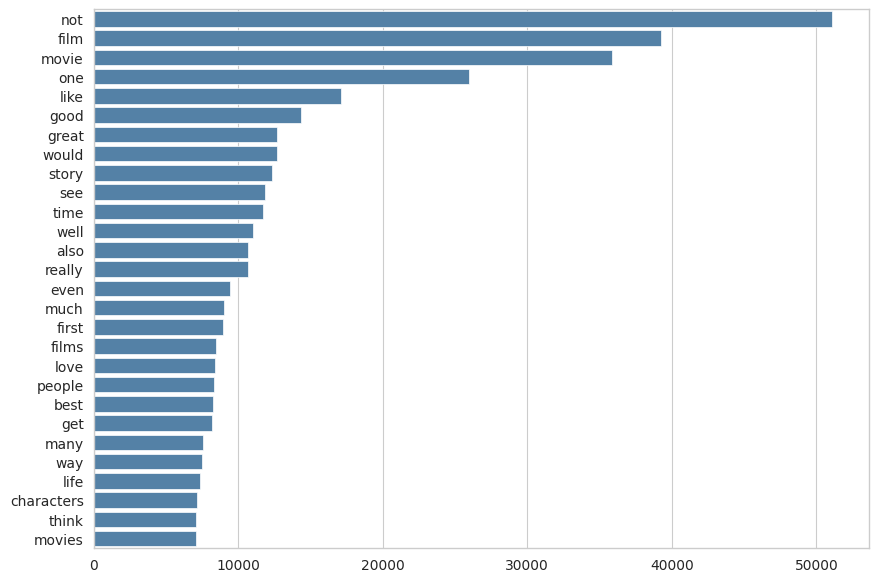

In [ ]:
corpus=create_corpus('positive')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.set_style("whitegrid")
sns.barplot(x=y,y=x, color='steelblue')

<Axes: >

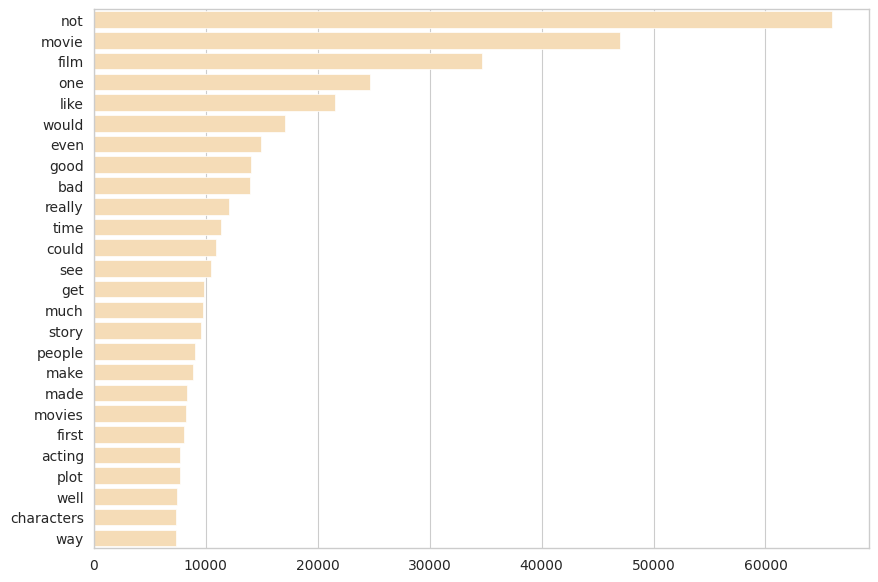

In [ ]:
corpus=create_corpus('negative')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.set_style("whitegrid")
sns.barplot(x=y,y=x, color='navajowhite')

Checking the most frequently used words doesn't show much difference between + and - reviews.

In [ ]:
def tokenize(review):
  review = review.lower()
  words = map(lambda x: x, word_tokenize(review))
  words = [word for word in words if word not in stops]
  tokens = (list(map(lambda x: PorterStemmer().stem(x), words)))

  return tokens

In [ ]:
def tfIdf(text):
  tfidf = TfidfVectorizer(tokenizer=tokenize, ngram_range=(2,2), min_df=30, max_features=10000, sublinear_tf=True)

  tfidf.fit(text)

  return tfidf

First I am using the Porter stemmer to normalize the words, and for analyzes I use the top 10 000 bi-grams

In [ ]:
data.sentiment = [ 1 if each == "positive" else 0 for each in data.sentiment]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data.review, data.sentiment, test_size=0.3, shuffle=True,random_state=SEED, stratify=data.sentiment)

In [ ]:
vectorizer = tfIdf(list(x_train))

In [ ]:
x_train_vec = vectorizer.transform(list(x_train))
x_test_vec = vectorizer.transform(list(x_test))

In [ ]:
def plot_importance(coefs, wordlist,modelname, top_n=20):
  coefs = coefs.ravel()

  top_pos = np.argsort(coefs)[-top_n:]
  top_neg = np.argsort(coefs)[:top_n]
  top_coefs = np.hstack([top_neg, top_pos])

  colors = ['navajowhite' if c < 0 else 'steelblue' for c in coefs[top_coefs]]

  f, ax = plt.subplots(figsize=(6,8))
  ax.set_title(f'N-gram importance for {modelname}')
  sns.set_style("whitegrid")
  ax.barh(np.arange(2*top_n), coefs[top_coefs], color=colors)
  feature_names = np.array(wordlist)
  ax.set_yticks(np.arange(2*top_n))
  ax.set_yticklabels(feature_names[top_coefs])
  plt.tight_layout()
  plt.show()

In [ ]:
def evaluate_models(train_x, train_y, test_x, test_y, models):
  metrics = pd.DataFrame()


# --------------SGDClassifier--------------
  sgd_est = models['sgd'].fit(train_x, train_y)

  test_pred_sgd = sgd_est.predict(test_x)
  test_pred_proba_sgd = sgd_est.predict_proba(test_x)

  metric_df = pd.DataFrame({
            'model': ['SGDClassifier'],
            'roc_auc_train': [cross_val_score(sgd_est, train_x, train_y, scoring="roc_auc", cv=StratifiedKFold(n_splits=5)).mean()],
            'roc_auc_test': [roc_auc_score(test_y, test_pred_proba_sgd[:, 1])],
            'accuracy': [accuracy_score(test_y, test_pred_sgd)],
            'precision': [precision_score(test_y, test_pred_sgd)],
            'log_loss': [log_loss(test_y, test_pred_proba_sgd)]
  })

  metrics = pd.concat([metrics, metric_df], axis=0)
  plot_importance(sgd_est.coef_, vectorizer.get_feature_names_out(),'SGDClassifier')

# --------------SVC--------------
  svc_est = models['svc'].fit(train_x, train_y)

  test_pred_svc = svc_est.predict(test_x)
  test_pred_proba_svc = svc_est.predict_proba(test_x)

  metric_df = pd.DataFrame({
            'model': ['LinearSVC'],
            'roc_auc_train': [cross_val_score(svc_est, train_x, train_y, scoring="roc_auc", cv=StratifiedKFold(n_splits=5)).mean()],
            'roc_auc_test': [roc_auc_score(test_y, test_pred_proba_svc[:, 1])],
            'accuracy': [accuracy_score(test_y, test_pred_svc)],
            'precision': [precision_score(test_y, test_pred_svc)],
            'log_loss': [log_loss(test_y, test_pred_proba_svc)]
  })

  metrics = pd.concat([metrics, metric_df], axis=0)
  #plot_importance(svc_est.coef_, vectorizer.get_feature_names_out(),'SVC')
  plot_importance(svc_est.calibrated_classifiers_[0].estimator.coef_, vectorizer.get_feature_names_out(),'LinearSVC')


# --------------Naive Bayes Multinomial--------------
  nbm_est = models['nbm'].fit(train_x, train_y)

  test_pred_nbm = nbm_est.predict(test_x)
  test_pred_proba_nbm = nbm_est.predict_proba(test_x)

  metric_df = pd.DataFrame({
            'model': ['Naive Bayes Multinomial'],
            'roc_auc_train': [cross_val_score(nbm_est, train_x, train_y, scoring="roc_auc", cv=StratifiedKFold(n_splits=5)).mean()],
            'roc_auc_test': [roc_auc_score(test_y, test_pred_proba_nbm[:, 1])],
            'accuracy': [accuracy_score(test_y, test_pred_nbm)],
            'precision': [precision_score(test_y, test_pred_nbm)],
            'log_loss': [log_loss(test_y, test_pred_proba_nbm)]
  })

  metrics = pd.concat([metrics, metric_df], axis=0)
  plot_importance(np.transpose(nbm_est.feature_log_prob_[:1,:]), vectorizer.get_feature_names_out(),'Naive Bayes Multinomial')

  # --------------LogisticRegression--------------
  lr_est = models['lr'].fit(train_x, train_y)

  test_pred_lr = lr_est.predict(test_x)
  test_pred_proba_lr = lr_est.predict_proba(test_x)

  metric_df = pd.DataFrame({
            'model': ['Logistic Regression'],
            'roc_auc_train': [cross_val_score(lr_est, train_x, train_y, scoring="roc_auc", cv=StratifiedKFold(n_splits=5)).mean()],
            'roc_auc_test': [roc_auc_score(test_y, test_pred_proba_lr[:, 1])],
            'accuracy': [accuracy_score(test_y, test_pred_lr)],
            'precision': [precision_score(test_y, test_pred_lr)],
            'log_loss': [log_loss(test_y, test_pred_proba_lr)]
  })

  metrics = pd.concat([metrics, metric_df], axis=0)
  plot_importance(lr_est.coef_, vectorizer.get_feature_names_out(),'Logistic Regression')


  # --------------DecisionTree--------------
  tree_est = models['tree'].fit(train_x, train_y)

  test_pred_tree = tree_est.predict(test_x)
  test_pred_proba_tree = tree_est.predict_proba(test_x)

  metric_df = pd.DataFrame({
            'model': ['DecisionTree'],
            'roc_auc_train': [cross_val_score(tree_est, train_x, train_y, scoring="roc_auc", cv=StratifiedKFold(n_splits=5)).mean()],
            'roc_auc_test': [roc_auc_score(test_y, test_pred_proba_tree[:, 1])],
            'accuracy': [accuracy_score(test_y, test_pred_tree)],
            'precision': [precision_score(test_y, test_pred_tree)],
            'log_loss': [log_loss(test_y, test_pred_proba_tree)]
  })

  metrics = pd.concat([metrics, metric_df], axis=0)
  plot_importance(tree_est.feature_importances_, vectorizer.get_feature_names_out(),'Decision Tree')


  fpr_sgd , tpr_sgd, _ =  roc_curve(y_test, test_pred_proba_sgd[:,1], pos_label=sgd_est.classes_[1])
  fpr_svc , tpr_svc, _ =  roc_curve(y_test, test_pred_proba_svc[:,1], pos_label=svc_est.classes_[1])
  fpr_nbm , tpr_nbm, _ =  roc_curve(y_test, test_pred_proba_nbm[:,1], pos_label=nbm_est.classes_[1])
  fpr_lr , tpr_lr, _ =  roc_curve(y_test, test_pred_proba_lr[:,1], pos_label=lr_est.classes_[1])
  fpr_tree , tpr_tree, _ =  roc_curve(y_test, test_pred_proba_tree[:,1], pos_label=tree_est.classes_[1])

  plt.plot([0,1],[0,1], 'k--')
  plt.plot(fpr_sgd , tpr_sgd, label= 'SGDClassifier')
  plt.plot(fpr_svc , tpr_svc, label= "LinearSVC")
  plt.plot(fpr_nbm , tpr_nbm, label= "Naive Bayes Multinominal")
  plt.plot(fpr_lr , tpr_lr, label= "Logistic Regression")
  plt.plot(fpr_tree , tpr_tree, label= "Decision tree")
  plt.legend()
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.title('Receiver Operating Characteristic')
  plt.show()

  return metrics

In [ ]:
sgd = SGDClassifier(loss='log')
svc = CalibratedClassifierCV(LinearSVC())
nbm = MultinomialNB()
lr = LogisticRegression()
tree = DecisionTreeClassifier()

models = {
    'sgd': sgd,
    'svc':svc,
    'nbm':nbm,
    'lr':lr,
    'tree':tree
}

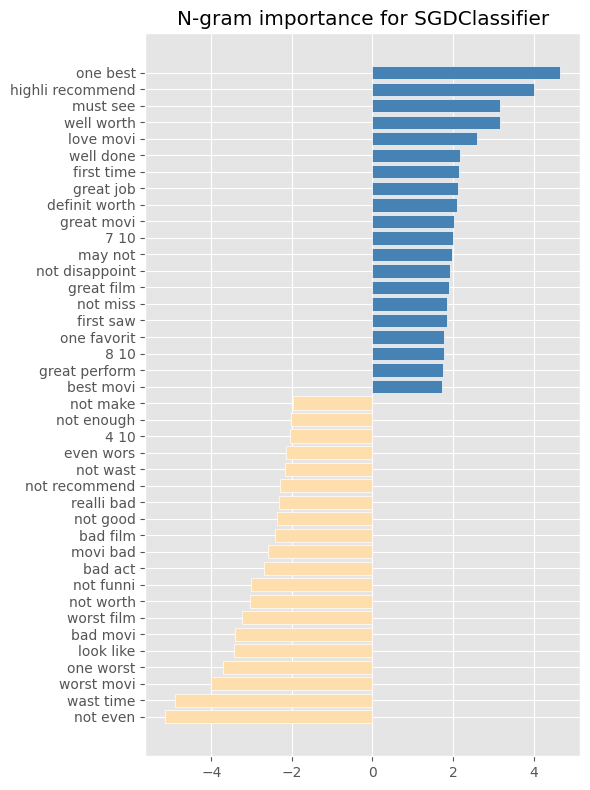

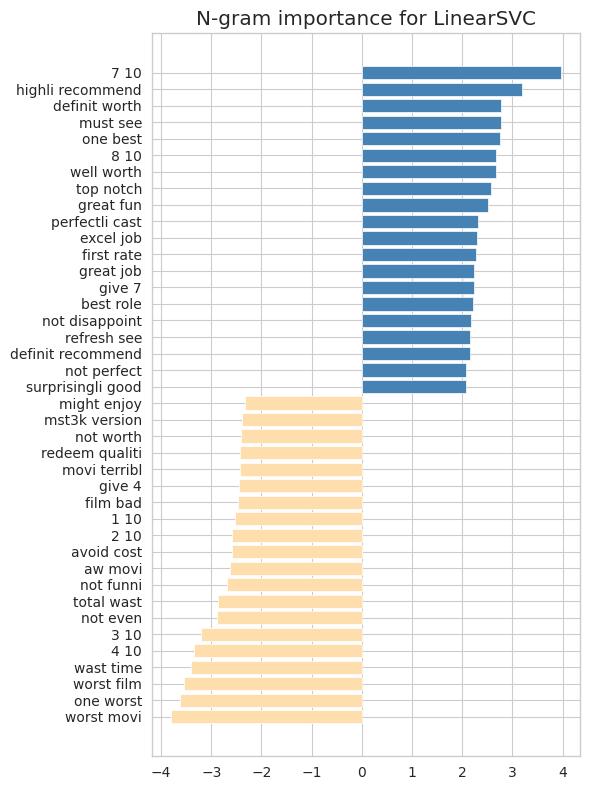

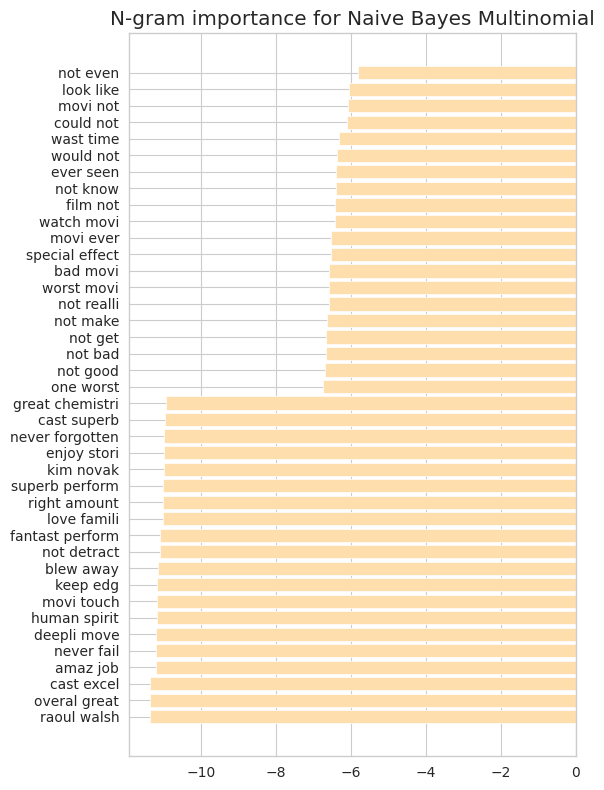

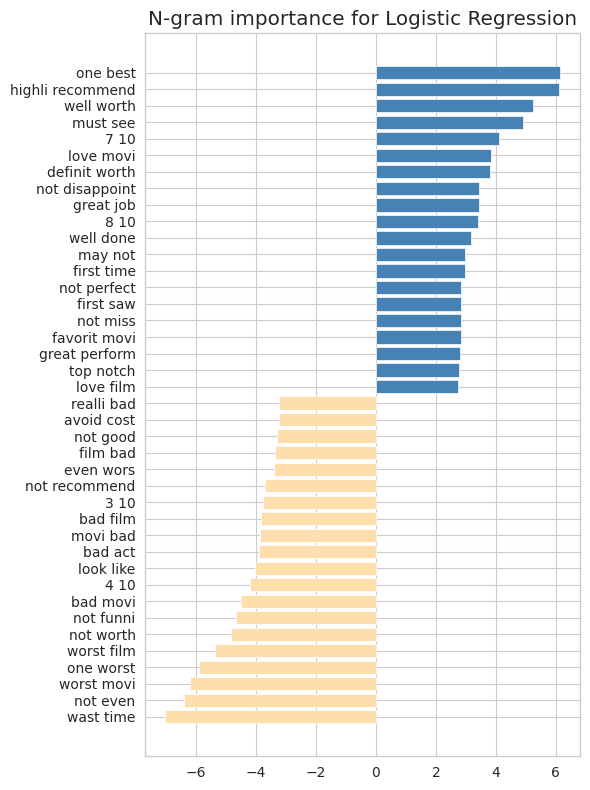

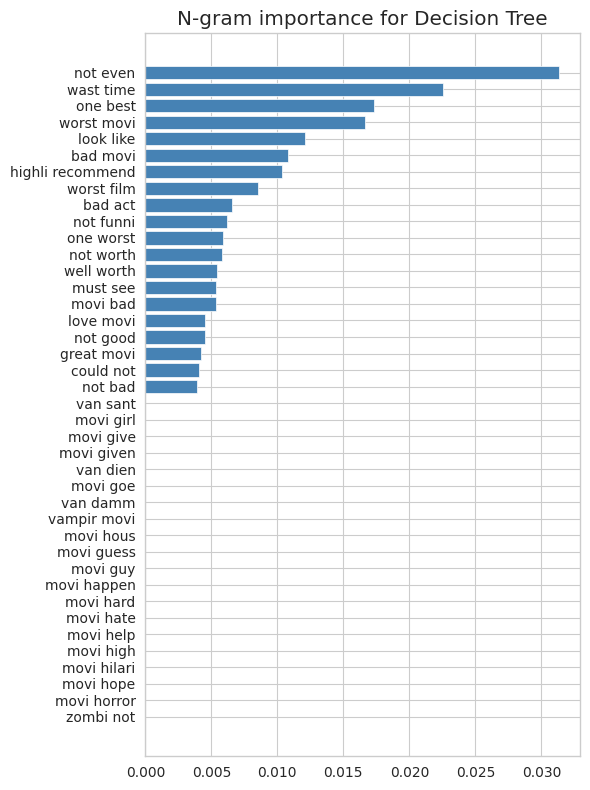

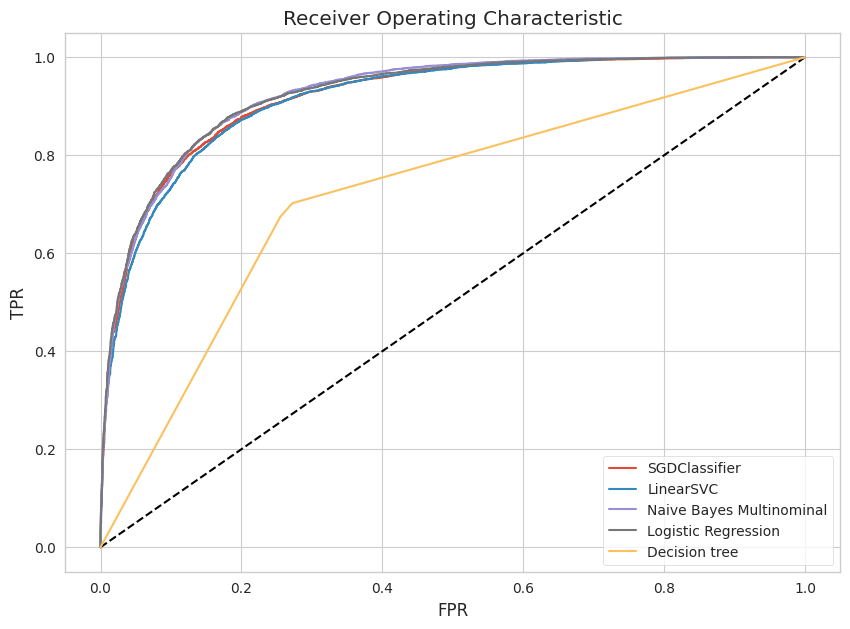

,model,roc_auc_train,roc_auc_test,accuracy,precision,log_loss
0,SGDClassifier,0.915935,0.919586,0.839395,0.819406,0.445486
0,LinearSVC,0.910993,0.915753,0.836504,0.828654,0.369868
0,Naive Bayes Multinomial,0.923769,0.925000,0.846387,0.833505,0.403548
0,Logistic Regression,0.920676,0.924853,0.847731,0.835224,0.379996
0,DecisionTree,0.702753,0.717082,0.714824,0.722000,9.988567


In [ ]:
metric = evaluate_models(x_train_vec, y_train, x_test_vec, y_test, models)
metric

I am comparing 5 different base models:

The Moltinomial Naiva Bayes gives the best ROC AUC score on the train set.

The Logisitc regression has a slightly lover score, but considering all the other metrics too, this model gives the best result.


Unfortunately, Decision Tree has much worse scores, than the other 4 models. We can see also in the most iist of most important bi-grams, that it is not so accurate.

We can see, that for each model, the train and test scores are very close to each other, and the test scores are slightly higher, than train scores. This can indicate that the models are underfitted.

In [ ]:
params = {
    'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'l1_ratio': [0.15, 0.1, 0.2]
}

gscv = GridSearchCV(estimator=sgd,
                    param_grid=params,
                    cv = StratifiedKFold(),
                    n_jobs=-1
                    )

In [ ]:
gscv.fit(x_train_vec, y_train)
gscv.best_params_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(loss='log'), n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01],
                         'l1_ratio': [0.15, 0.1, 0.2],
                         'penalty': ['l2', 'l1', 'elasticnet']})

{'alpha': 1e-05, 'l1_ratio': 0.15, 'penalty': 'elasticnet'}

In [ ]:
params = {
    'estimator__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'estimator__penalty': ['l2', 'l1'],
    'estimator__loss': ['hinge', 'squared_hinge']
}

gsvm = GridSearchCV(estimator=svc,
                    param_grid=params,
                    cv = StratifiedKFold(),
                    n_jobs=-1
                    )

In [ ]:
gsvm.fit(x_train_vec, y_train)
gsvm.best_params_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=CalibratedClassifierCV(estimator=LinearSVC()), n_jobs=-1,
             param_grid={'estimator__C': [1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                          0.1, 1],
                         'estimator__loss': ['hinge', 'squared_hinge'],
                         'estimator__penalty': ['l2', 'l1']})

{'estimator__C': 0.1,
 'estimator__loss': 'squared_hinge',
 'estimator__penalty': 'l2'}

In [ ]:
params = {
    'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
}

gnbm = GridSearchCV(estimator=nbm,
                    param_grid=params,
                    cv = StratifiedKFold(),
                    n_jobs=-1
                    )

In [ ]:
gnbm.fit(x_train_vec, y_train)
gnbm.best_params_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]})

{'alpha': 1}

In [ ]:
params = {
    'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'l1_ratio': [0.15, 0.1, 0.2]
}

glr = GridSearchCV(estimator=lr,
                    param_grid=params,
                    cv = StratifiedKFold(),
                    n_jobs=-1
                    )

In [ ]:
glr.fit(x_train_vec, y_train)
glr.best_params_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'l1_ratio': [0.15, 0.1, 0.2],
                         'penalty': ['l1', 'l2', 'elasticnet']})

{'C': 1, 'l1_ratio': 0.15, 'penalty': 'l2'}

In [ ]:
params = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [5, 6, 7, 8, 9, 10],
    'criterion' :['gini', 'entropy']
  }

gtree = GridSearchCV(estimator=tree,
                    param_grid=params,
                    cv = StratifiedKFold(),
                    n_jobs=-1
                    )

In [ ]:
gtree.fit(x_train_vec, y_train)
gtree.best_params_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 'sqrt', 'log2']})

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt'}

In [ ]:
sgd = SGDClassifier(loss='log', alpha=1e-05, l1_ratio=0.15, penalty='elasticnet')
svc = CalibratedClassifierCV(LinearSVC(C=0.1, loss='squared_hinge', penalty='l2'))
nbm = MultinomialNB(alpha=1)
lr = LogisticRegression(C=1, penalty='l2')
tree = DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=10, max_features='sqrt')

models = {
    'sgd': sgd,
    'svc':svc,
    'nbm':nbm,
    'lr':lr,
    'tree':tree
}

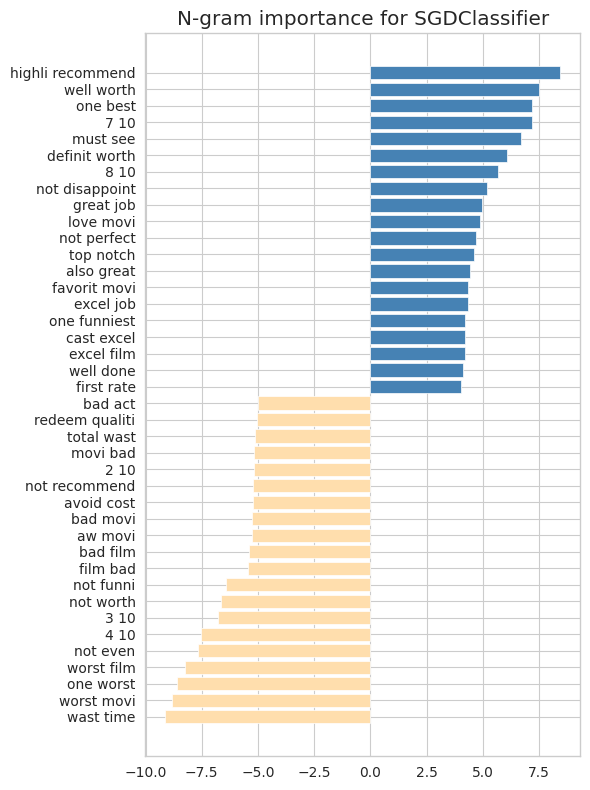

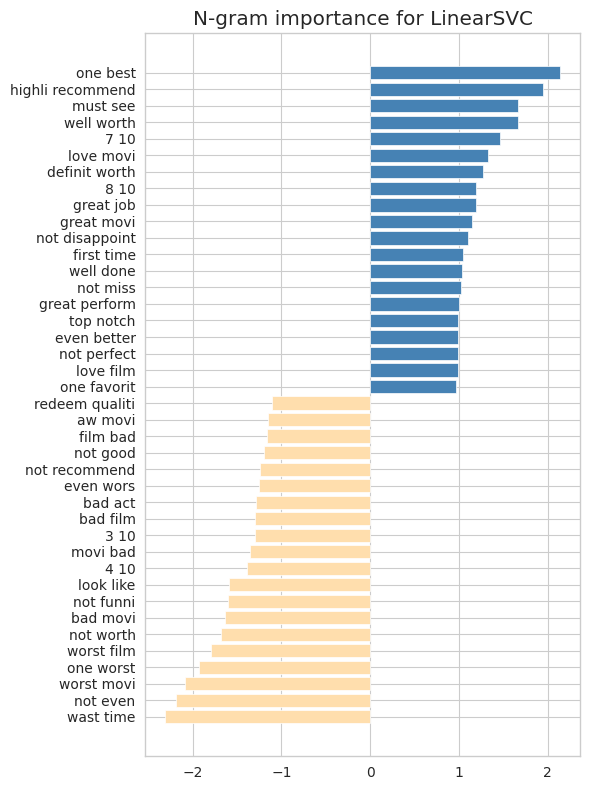

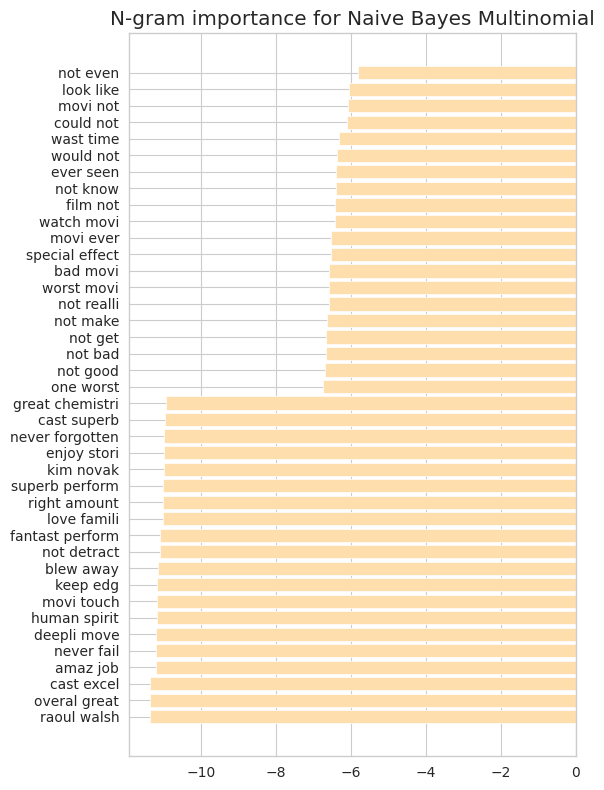

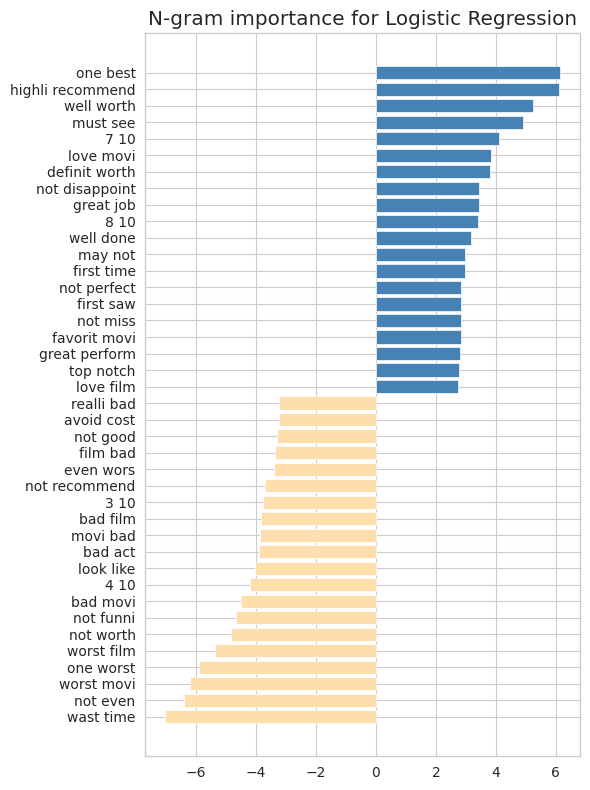

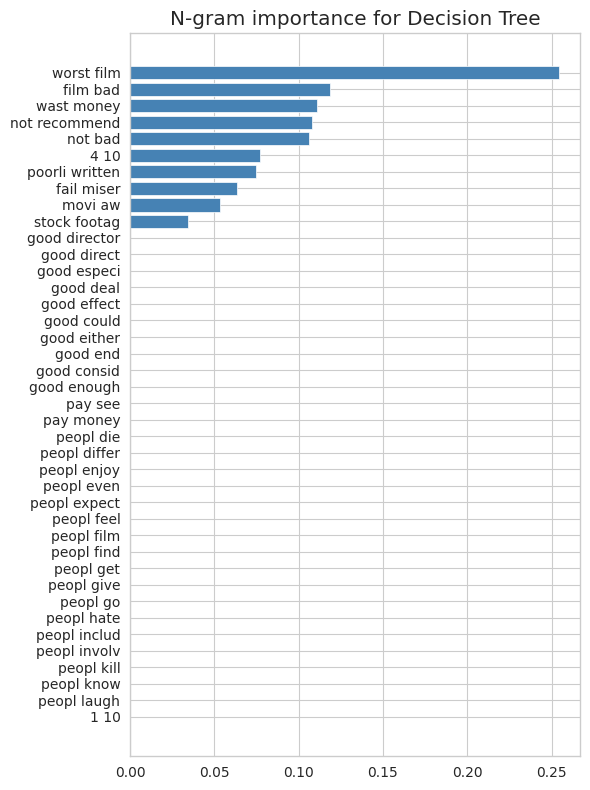

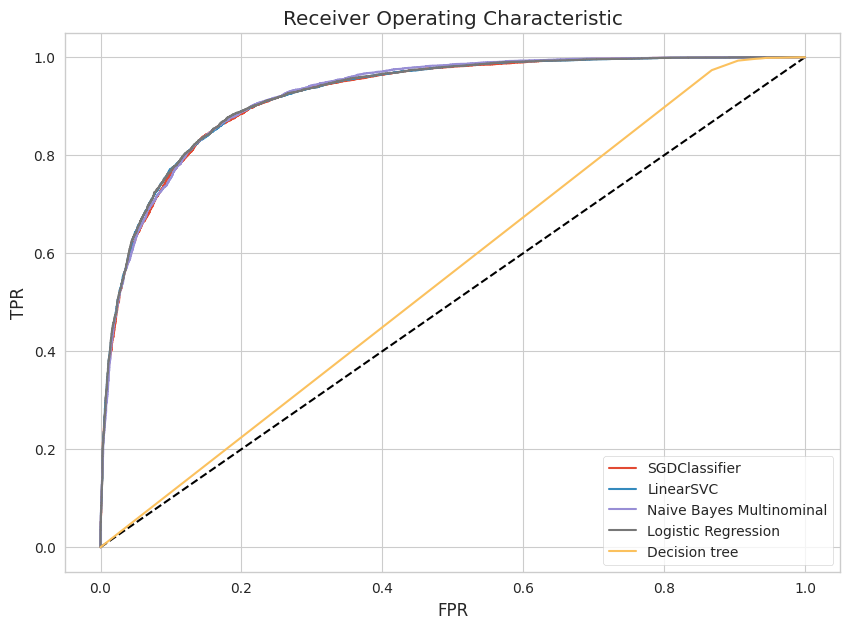

,model,roc_auc_train,roc_auc_test,accuracy,precision,log_loss
0,SGDClassifier,0.917793,0.922964,0.845647,0.840021,0.355954
0,LinearSVC,0.920323,0.924512,0.844908,0.836948,0.350089
0,Naive Bayes Multinomial,0.923769,0.925000,0.846387,0.833505,0.403548
0,Logistic Regression,0.920676,0.924853,0.847731,0.835224,0.379996
0,DecisionTree,0.554431,0.553923,0.554555,0.530627,0.667035


In [ ]:
metric = evaluate_models(x_train_vec, y_train, x_test_vec, y_test, models)
metric

After the hyperparameter tuning, we can't see siginificant increase in the scores.

For decision tree, we got worse results, than before

In [ ]:
def tokenize_lem(review):
  review = review.lower()
  words = map(lambda x: x, word_tokenize(review))
  words = [word for word in words if word not in stops]
  tokens = (list(map(lambda x: WordNetLemmatizer().lemmatize(x), words)))

  return tokens

In [ ]:
def tfIdf_lem(text):
  tfidf = TfidfVectorizer(tokenizer=tokenize_lem, ngram_range=(2,2), min_df=30, max_features=10000, sublinear_tf=True)

  tfidf.fit(text)

  return tfidf

In [ ]:
vectorizer = tfIdf_lem(list(x_train))

In [ ]:
x_train_vec_l = vectorizer.transform(list(x_train))
x_test_vec_l = vectorizer.transform(list(x_test))

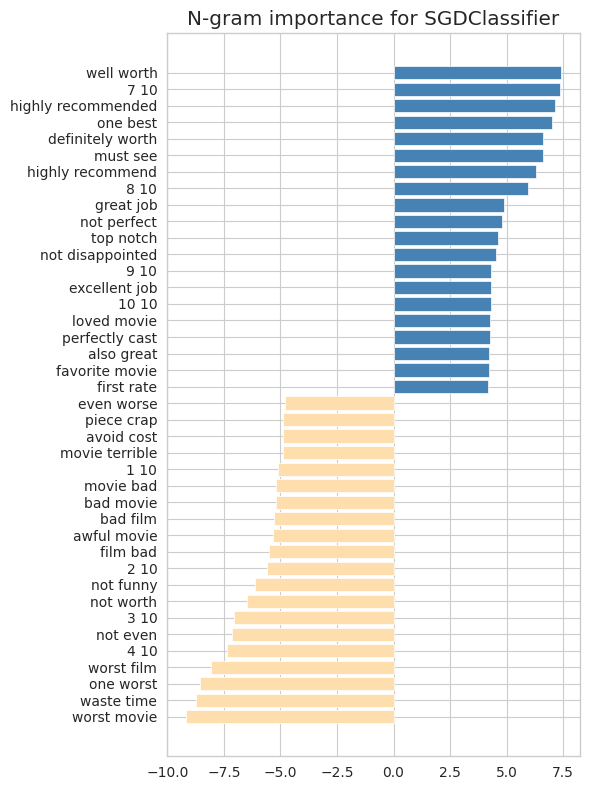

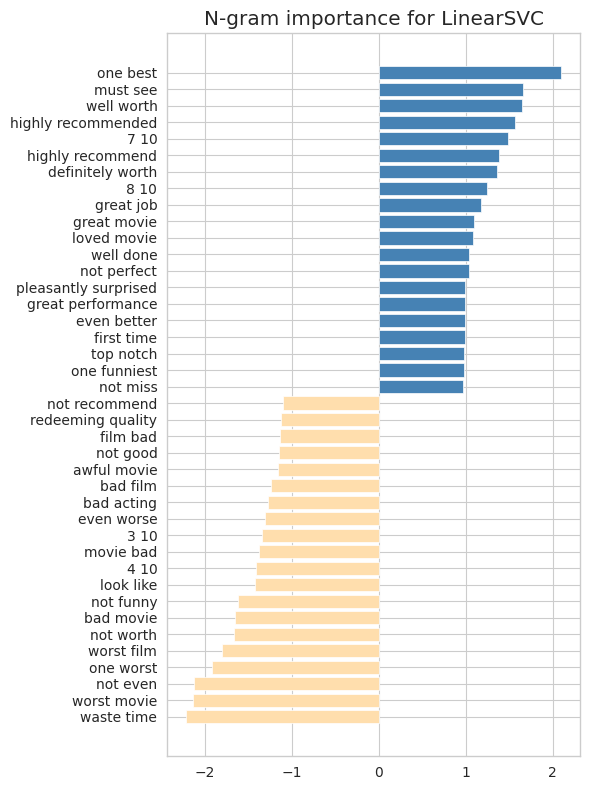

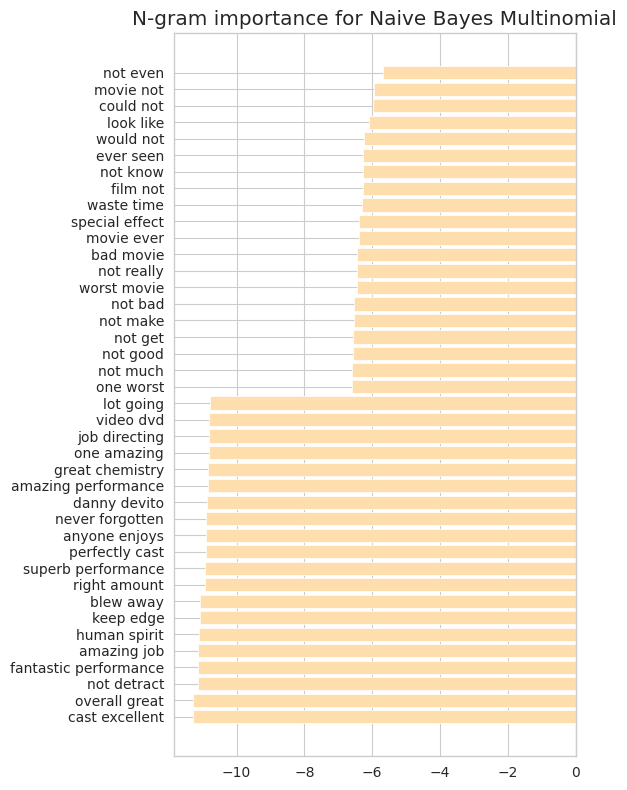

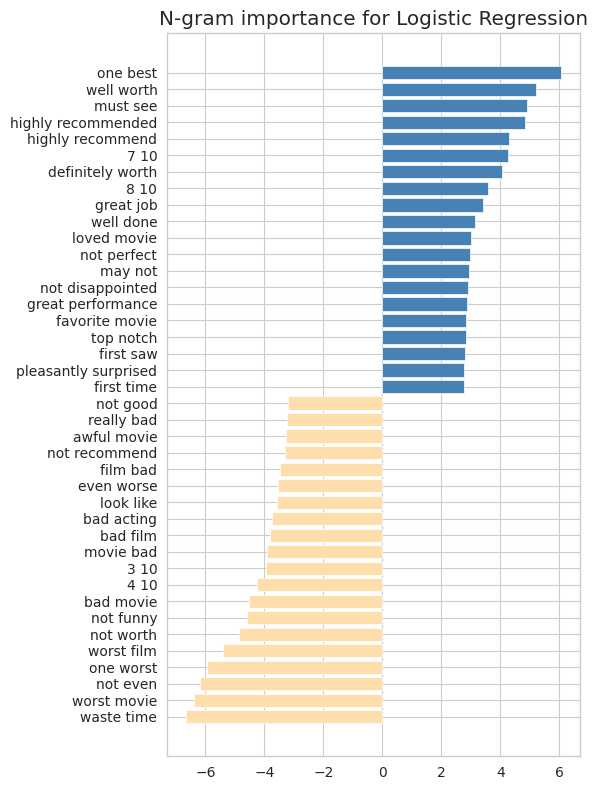

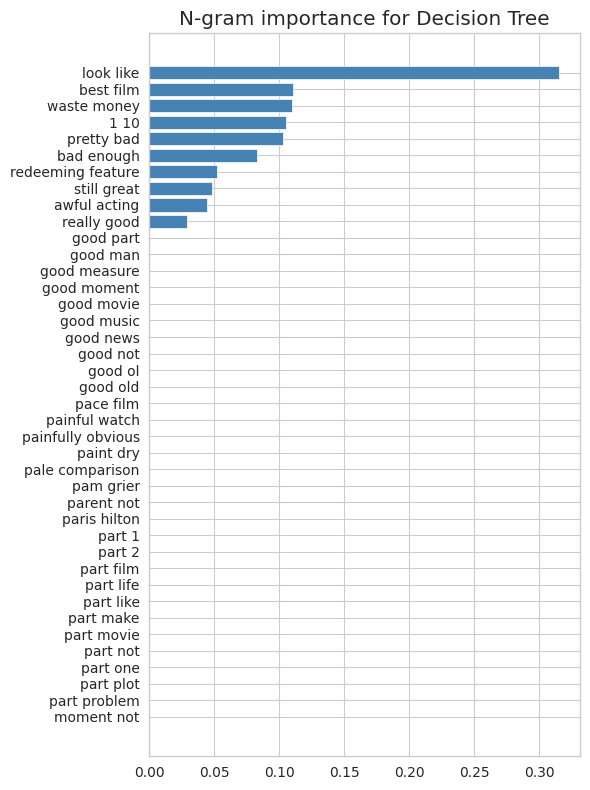

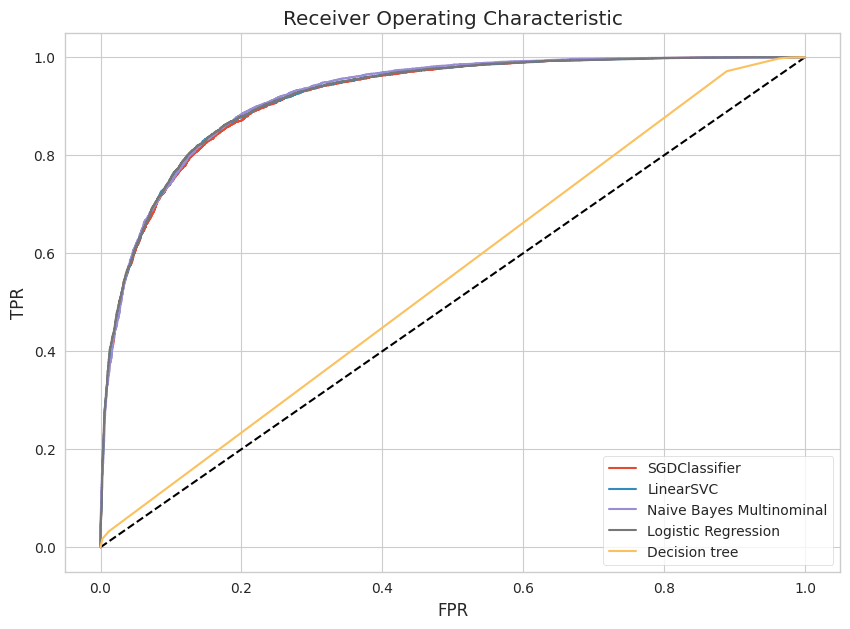

,model,roc_auc_train,roc_auc_test,accuracy,precision,log_loss
0,SGDClassifier,0.911491,0.918639,0.838655,0.835831,0.364277
0,LinearSVC,0.914213,0.920278,0.842218,0.834597,0.359228
0,Naive Bayes Multinomial,0.918653,0.922051,0.841613,0.828469,0.407278
0,Logistic Regression,0.914662,0.920725,0.843092,0.831417,0.386051
0,DecisionTree,0.547161,0.550365,0.542857,0.524026,0.674208


In [ ]:
metric = evaluate_models(x_train_vec_l, y_train, x_test_vec_l, y_test, models)
metric

I've also tried lemmatization for normalizing the words

However, in this case, with stemming, we had better results.

So we can say that considering only ROC AUC, we had the best result with Multinomial Naive Bayes.


If we also considering accuracy, precision and log loss, Logistic Regression is the best choice.